# Homework 4

Run the DBSCAN algorithm on the digits dataset from last week.
1. Find a value for `eps` that produces ten clusters (not counting outliers), and calculate the accuracy.
2. Find values of `eps` that give a different number of clusters. Can you explain the choice of clusters with these hyperparameters. (Eg. if there are nine clusters, maybe they roughly correspond to digit classes, but 7 and 1 are counted as one class. If there are 11, maybe 7s with or without a crossed line count as different classes.)
3. Visualise a few examples of each cluster for the 10-cluster system, as well as some outliers. Do you see an explanation as to why those datapoints would be considered outliers?

# Setup

## Libraries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import itertools

from sklearn.datasets import load_digits
from sklearn.preprocessing import MaxAbsScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn import metrics

from scipy.stats import mode

## Digits dataset

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 1797
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

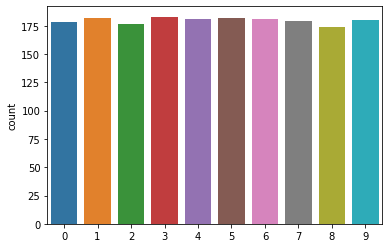

In [2]:
# load dataset
digits = load_digits()
# extract train features and target
X, y = digits.data, digits.target
# transformation of features
X_normed = MaxAbsScaler().fit_transform(X)
# print description of the data
print(digits.DESCR)
# glimpse on feature dimensions
print(X.shape)
print(y.shape)
# display number of labelled observations per each digit
sns.countplot(x=y)
plt.show()

array([2, 2, 4, 8, 6, 1, 5, 1, 3, 0])

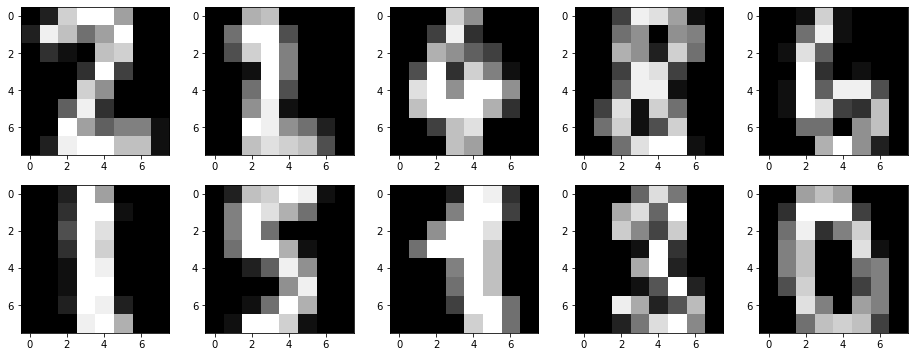

In [3]:
# display a few, random examples
plt.figure(figsize=(16, 6))
samples = np.random.randint(0, X.shape[0]+1, 10)
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X[samples[i],:].reshape([8,8]), cmap='gray')
y[samples]

# K-means

In [4]:
# run k-means clustering algorithm, simiarly to last week to get a baseline accuracy
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters)
y_kmeans = kmeans.fit_predict(X_normed)

labels = np.zeros_like(y_kmeans)
for i in range(10):
    labels[(y_kmeans == i)] = mode(digits.target[(y_kmeans == i)])[0]
metrics.accuracy_score(y, labels)

0.7924318308291597

# DBSCAN

## Part1

Find a value for `eps` that produces ten clusters (not counting outliers), and calculate the accuracy.

In [5]:
# I will implement a basis grid search algorithm.

# First, define a grid of selected eps range and all possible metrics
params = list(itertools.product(np.arange(0.5, 2, 0.1), ['cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan']))

# Then, run gridsearch for all parameter combination
results = []
for eps, metric in params:
    db = DBSCAN(eps=eps, metric=metric).fit(X_normed)
    y_dbscan = db.labels_
    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(y_dbscan)) - (1 if -1 in y_dbscan else 0)

    data = pd.DataFrame({'target': y,
                         'prediction': y_dbscan})
    # map the actual label of a cluster by checking i.e. the mode of the targets of datapoints inside that cluster
    mapper = {i: mode(data.loc[data['prediction'] == i, 'target'].tolist())[0][0] for i in range(n_clusters_)}
    data['prediction_labels'] = data['prediction'].map(mapper)
    data['prediction_labels'] = data['prediction_labels'].fillna(-1)
    labels = data.prediction_labels
    #core_samples_mask = np.zeros_like(labels, dtype=bool)
    #core_samples_mask[db.core_sample_indices_] = True


    # Number of noisy observations
    n_noise_ = list(labels).count(-1)
    # calculate metrics and store result
    result = [eps, metric, n_clusters_, n_noise_, labels,
               metrics.homogeneity_score(y, labels), metrics.completeness_score(y, labels),
               metrics.v_measure_score(y, labels), metrics.adjusted_rand_score(y, labels),
               metrics.adjusted_mutual_info_score(y, labels), metrics.accuracy_score(y, labels)]
    results.append(result)
# create a dataframe storing results of all runs
df = pd.DataFrame(results, columns=['eps', 'metric', 'n_clusters', 'n_noise', 'labels',
                                    'homogeneity_score', 'completeness_score',
                                    'v_measure_score', 'adjusted_rand_score',
                                    'adjusted_mutual_info_score', 'accuracy_score'])

In [6]:
# display parameter combination and accuracy scores where n_clusters == 10
df.query('n_clusters == 10')

,eps,metric,n_clusters,n_noise,labels,homogeneity_score,completeness_score,v_measure_score,adjusted_rand_score,adjusted_mutual_info_score,accuracy_score
56,1.4,euclidean,10,219,0 0.0 1 6.0 2 -1.0 3 5....,0.657368,0.783448,0.714891,0.498494,0.712063,0.570395
58,1.4,l2,10,219,0 0.0 1 6.0 2 -1.0 3 5....,0.657368,0.783448,0.714891,0.498494,0.712063,0.570395


We can see above that `eps=1.4` with either `metric=euclidean` or `metric=l2` also produced `n_clusters=10` with around `57%` accuracy.

## Part 2

Find values of `eps` that give a different number of clusters. Can you explain the choice of clusters with these hyperparameters. (Eg. if there are nine clusters, maybe they roughly correspond to digit classes, but 7 and 1 are counted as one class. If there are 11, maybe 7s with or without a crossed line count as different classes.)

In [7]:
results = {}
for eps in np.arange(0.5, 2, 0.01):
    db = DBSCAN(eps=eps).fit(X_normed)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    results[f'{eps:.2f}'] = [n_clusters_]

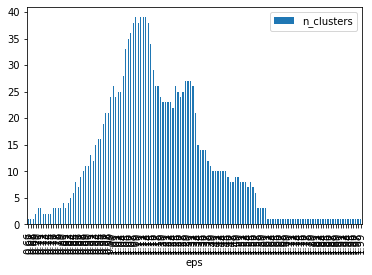

In [8]:
df_eps = pd.DataFrame(results, index=['n_clusters']).T.reset_index().rename({'index': 'eps'}, axis=1).set_index('eps').query('n_clusters > 0')
df_eps.plot(kind='bar')
plt.show()

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

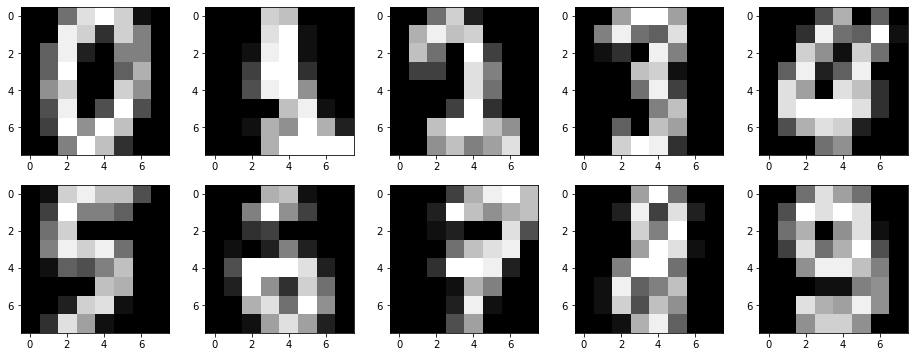

In [9]:
# display a few examples
plt.figure(figsize=(16, 6))
samples = [np.random.choice(np.where(y == i)[0]) for i in range(10)]
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X[samples[i],:].reshape([8,8]), cmap='gray')
y[samples]

array([9, 9, 9, 9, 9, 9, 9, 9, 9, 9])

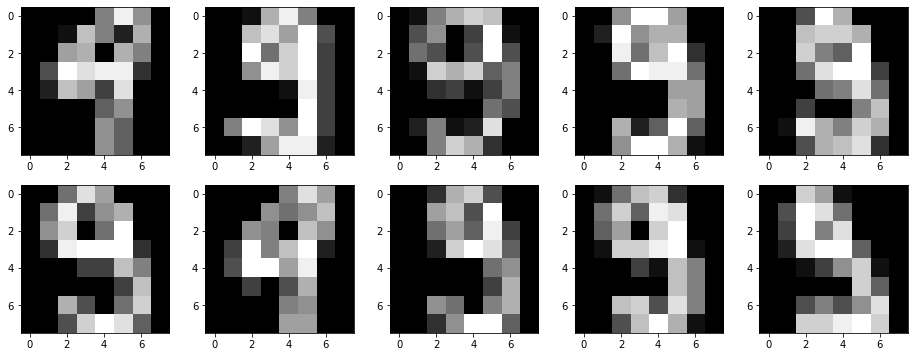

In [10]:
# display a few examples
plt.figure(figsize=(16, 6))
samples = np.random.choice(np.where(y == 9)[0], 10)
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X[samples[i],:].reshape([8,8]), cmap='gray')
y[samples]

In [11]:
df.loc[df.accuracy_score.argmax(), :]

eps                                                                         1.3
metric                                                                euclidean
n_clusters                                                                   27
n_noise                                                                     377
labels                        0       0.0
1       1.0
2      -1.0
3       3....
homogeneity_score                                                      0.786073
completeness_score                                                     0.787199
v_measure_score                                                        0.786636
adjusted_rand_score                                                    0.619874
adjusted_mutual_info_score                                             0.784247
accuracy_score                                                         0.771285
Name: 50, dtype: object

We can see from a random sample of unique numbers and a random sample from a fixed digit that the dataset is very noisy and it's difficult to distingush the numbers by eye as well. We can group similar looking numbers together to get smaller cluster numbers, and also we could explain higher cluster dimension by grouping similar noisy data together. For example, you can see that by manually searching through the combinations of `eps` and `metric` parameters, the best `accuracy_score` was around `77%` which was close to what we could get by the `k-means` baseline algorithm, but the `DBSCAN` produced this result by creating `n_clusters=27`.

## Part3

Visualise a few examples of each cluster for the 10-cluster system, as well as some outliers. Do you see an explanation as to why those datapoints would be considered outliers?

In [12]:
df.query('n_clusters == 10')

,eps,metric,n_clusters,n_noise,labels,homogeneity_score,completeness_score,v_measure_score,adjusted_rand_score,adjusted_mutual_info_score,accuracy_score
56,1.4,euclidean,10,219,0 0.0 1 6.0 2 -1.0 3 5....,0.657368,0.783448,0.714891,0.498494,0.712063,0.570395
58,1.4,l2,10,219,0 0.0 1 6.0 2 -1.0 3 5....,0.657368,0.783448,0.714891,0.498494,0.712063,0.570395


In [17]:
labels = df.query('n_clusters == 10').loc[56, 'labels']
result = pd.DataFrame({'labels_true': y, 'labels_predicted': labels.astype(int)})
correct_predictions = result.query('labels_true == labels_predicted').index.to_list()
false_predictions = result.query('labels_true != labels_predicted and labels_predicted != -1').index.to_list()
result

,labels_true,labels_predicted
0,0,0
1,1,6
2,2,-1
3,3,5
4,4,4
...,...,...
1792,9,5
1793,0,0
1794,8,6
1795,9,5


,labels_true,labels_predicted
1527,7,7
1469,2,2
825,0,0
1449,6,6
1106,0,0
597,7,7
1225,4,4
188,6,6
1469,2,2
1567,4,4


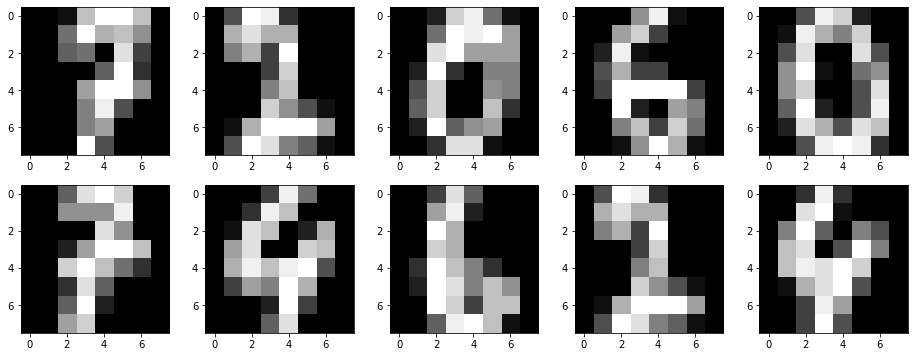

In [18]:
# display a few examples of corect predictions
plt.figure(figsize=(16, 6))
samples = np.random.choice(correct_predictions, 10)
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X[samples[i],:].reshape([8,8]), cmap='gray')
result.loc[samples]

The accurate prediction are pretty readable, maybe except for the number `4`.

,labels_true,labels_predicted
669,3,5
1015,8,6
904,9,5
1621,1,6
1511,8,6
60,3,5
226,3,5
1280,8,6
394,8,6
1766,1,6


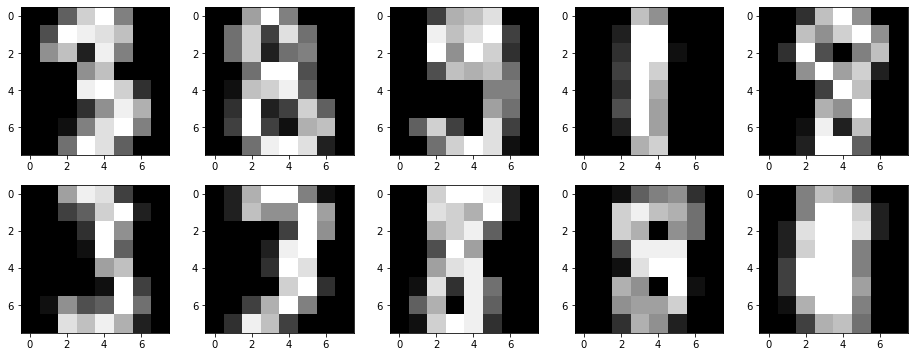

In [19]:
# display a few examples of false predictions
plt.figure(figsize=(16, 6))
samples = np.random.choice(false_predictions, 10)
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X[samples[i],:].reshape([8,8]), cmap='gray')
result.loc[samples]

The mis-labelled predictions are generally low quality and are hard to read, for example, I would not be able to tell that the last picture actually corresponds to number `1`.